# Klassifikation

In diesem Notebook werden verschiedene Klassifikationsmodelle trainiert. Ziel ist es, die Städte im Datensatz aufgrund ihrer Feinstaubbelastung in zwei Klassen einzuteilen. Als Zielvariable wird also die Belastung mit mittelgroßen Feinstaubpartikeln (PM2.5, gemessen in µg/m³) angesetzt. 

Als Schwellenwert werden zwei Ansätze getestet:
1. WHO-Richtline von 5 µg/m³: fachlicher Standard
2. Median: datengetriebene Größe

Als Modelle werden verglichen:
1. Logistische Regression
2. Random Forest
3. Gradient Boosting

Verwendet werden verschiedene Module der Python Bibliothek **Scitkit-learn** für maschinelles Lernen

📌 **Datenstand:** `cleaned_air_quality_data_2025-03-27.csv`  
📁 **Importiert aus:** lokaler Datei (--> gitignore)

## 📚 Inhaltsverzeichnis 
(Diese Art von Inhaltsverzeichnis mit Link funktioniert leider in Notebooks nicht, weil die as JSON gespeichert werden und nicht als HTML...)

- [0. Datensatz laden](#0-datensatz-laden)
- [1. Dataframe vorbereiten](#1-dateframe-vorbereiten)
- [2. WHO-Richtlinie](#2-who-richtlinie)
- [3. Median der Zielvariablen](#3-median-der-zielvariablen)
- [4. Features, Target, Train-/Test-Split](#4-features-target-train-test-split)
- [5. Logistic Regression](#5-logistic-regression)
- [6. Random Forest](#6-random-forest)
- [7. Gradient Boosting](#7-gradient-boosting)


# 0. Datensatz laden

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline

In [2]:
df = pd.read_csv("data/cleaned_air_quality_data_2025-03-27.csv")
df.head()

,Year,Month,Day,Country,City,Latitude,Longitude,Population,Co,No2,...,So2,Dew,Humidity,Tavg,Tmin,Tmax,Prcp,Wdir,Wspd,Pres
0,2019,2,28,SA,Abha,18.21639,42.50528,5616633.0,NaN,NaN,...,NaN,6.0,45.0,18.8,15.8,24.1,NaN,183.0,21.9,1022.3
1,2019,3,1,SA,Abha,18.21639,42.50528,5616633.0,NaN,NaN,...,NaN,12.0,64.0,17.0,13.5,23.0,NaN,185.0,21.2,1021.9
2,2019,3,2,SA,Abha,18.21639,42.50528,5616633.0,NaN,0.0,...,0.0,9.0,63.0,16.7,10.8,23.6,NaN,186.0,15.2,1022.3
3,2019,3,3,SA,Abha,18.21639,42.50528,5616633.0,NaN,0.0,...,0.0,6.0,55.0,15.9,10.8,22.0,NaN,196.0,16.5,1023.4
4,2019,3,4,SA,Abha,18.21639,42.50528,5616633.0,NaN,0.0,...,0.0,3.0,58.0,16.1,9.0,22.5,NaN,NaN,11.2,1023.8


# 1. Dateframe vorbereiten

Als Target benutzen wir mittelgroße Feinstaubpartikel (PM2.5), als Features alle anderen Schadstoffe im Datensatz: CO, NO₂, SO₂, O₃ und (im allerersten Modell) PM10.

Weil das Imputieren von Werten für nicht vorhandenen Kategorien (Schadstoffen) für eine Stadt nicht mehr als "Raten" ist, werden nur Städte in die Analyse mit aufgenommen, für die Messwerte zu allen sechs Luftschadstoffen vorliegen. (--> Wiebke: Was ich meine, ist: Ich kann innerhalb einer Stadt Werte imputieren, aber es ist ziemlicher Quatsch, die Werte von einer Stadt auf die andere zu übertragen, also stadtübergreifend zu imputieren.)

Die Luftqualität kann auch auf dem arithmetischen Mittel berechnet werden. Dies hat den Vorteil, dass die natürliche Varianz besser abgebildet wird und den Nachteil, dass Machine-Learning-Modelle sich bei der Klassifikation schlechter abschneiden. Beide Varianten wurden komplett durchgerechnet. Da hier das Verhalten unterschiedlicher Klassifikationsmodelle gezeigt werden soll, wurde für die finale Analyse der Median gewählt.

In [3]:
# Liste relevanter Schadstoffe
pollutants = ['Co', 'No2', 'O3', 'Pm10', 'Pm25', 'So2']

In [4]:
# Mittelwerte pro Stadt berechnen (Index = City)
df_median = df.groupby('City')[pollutants].median()

In [5]:
# Für jede Stadt: Wie viele Mittelwerte sind vorhanden?
df_median['Num_Valid_Pollutants'] = df_median[pollutants].notna().sum(axis=1)

# Übersicht: Wie viele Städte haben wie viele gültige Schadstoffwerte?
coverage_summary = df_median['Num_Valid_Pollutants'].value_counts().sort_index()

# Ergebnis anzeigen
coverage_summary

Num_Valid_Pollutants
0     13
1     26
2     21
3     12
4     40
5     98
6    406
Name: count, dtype: int64

In [6]:
# Nur Städte mit allen 6 Schadstoff-Mittelwerten

df_median_complete = df_median[df_median['Num_Valid_Pollutants'] == 6]

len(df_median_complete)

406

Der Dataframe enthält nun 406 Städte, für die jeweils Werte für jeden Schadstoff vorliegen.

# 2. WHO-Richtlinie

Als erstes wird die Klasseneinteilung auf der Grundlage einen fachlichen Standards, nämlich des aktuellen WHO-Grenzwerts für PM2.5 von 5 µg/m³ vorgenommen:

In [7]:
# Anzahl Städte mit guter/schlechter Luft (nach WHO-Grenzwert)
(df_median_complete['Pm25'] <= 5).value_counts()

Pm25
False    404
True       2
Name: count, dtype: int64

In [8]:
# Städte mit PM2.5 ≤ 5 µg/m³ filtern
clean_cities = df_median_complete[df_median_complete['Pm25'] <= 5]

# Ergebnis anzeigen
clean_cities

,Co,No2,O3,Pm10,Pm25,So2,Num_Valid_Pollutants
City,,,,,,,
Plovdiv,0.1,9.3,19.1,25.0,2.0,3.9,6
Yazd,22.0,35.0,0.0,61.0,0.0,22.0,6


In [9]:
# Anzahl gültiger PM2.5-Werte pro Stadt
pm25_counts = df.groupby('City')['Pm25'].count().sort_values()

# Zeige nur die "sauberen" Städte
pm25_counts.loc[['Plovdiv', 'Yazd']]

City
Plovdiv      1
Yazd       114
Name: Pm25, dtype: int64

Dem WHO-Grenzwert entsprechen in unserem Datensatz nur zwei von 406 Städten: Plovdiv (Bulgarien), Yazd (Iran). Bei genauerem Hinschauen fällt allerdings auf, dass es für Plovidiv nur einen einzigen Messwert gibt und für Yazd nur sehr wenige. Die Messwerte sind damit nicht aussagekräftig.

Die WHO-Richtline kann also für das Training von Klassifikationsmodellen nicht als Schwellenwert verwendet werden - es hätte keine zweite Klasse, von der es lernen könnte.

**OFFENE FRAGE**: Ist es gut, für die restliche Analyse alle Städte drinzulassen, auch wenn sie nur wenige Messwerte pro Schadstoff haben? Sollte man da noch was aussortieren? Oder einfach mal so lassen, weil in der Realität die Datenqualität auch nur selten optimal ist?

# 3. Median der Zielvariablen

Als Alternative wird der Median als datengetriebener Grenzwert gewählt. Die Einteilung in Städte mit guter und schlechter Luftqualität basiert also auf dem Medianwert der durchschnittlichen PM2.5-Konzentration aller Städte im Datensatz. 

Durch die Verwendung des Medians entsteht eine ausgewogene Verteilung zwischen den beiden Klassen, die ein stabiles Training und eine faire Bewertung des Modells ermöglicht.

Um ein Klassifikationsmodell zur Vorhersage der Luftqualität von Städten zu erstellen, wird eine Zielvariable mit dem Namen **AirQualityLabel** eingeführt. Diese ordnet jeder Stadt eine von zwei Klassen zu:

- 0 → Gute Luftqualität

- 1 → Schlechte Luftqualität

Die Luftqualität wird aus den Medianen der einzelnen Schadstoffe pro Stadt berechnet. Städte mit einem PM2.5-Mittelwert über dem Median werden als "schlechte Luftqualität" (1) klassifiziert, alle anderen als "gute Luftqualität" (0).

In [10]:
df_classification = df_median_complete.copy()

# Median von PM2.5 berechnen
pm25_median = df_classification['Pm25'].median()

# Zielvariable hinzufügen
df_classification['AirQualityLabel'] = (df_classification['Pm25'] > pm25_median).astype(int)

In [11]:
# Umgang mit NaN-Werten

# Anzahl fehlender Werte pro Spalte
df_classification[pollutants].isna().sum()

Co      0
No2     0
O3      0
Pm10    0
Pm25    0
So2     0
dtype: int64

In [14]:
df_classification.sample(10)

,Co,No2,O3,Pm10,Pm25,So2,Num_Valid_Pollutants,AirQualityLabel
City,,,,,,,,
Oklahoma city,4.5,6.5,28.1,18.0,33.0,1.5,6,0
Swansea,3.0,5.7,22.8,15.0,34.0,1.0,6,0
Hamburg,0.1,10.1,20.8,14.0,38.0,1.6,6,0
Sapporo,3.4,7.5,24.8,9.0,25.0,1.5,6,0
Liège,0.1,7.4,19.5,13.0,30.0,1.1,6,0
Lille,0.1,8.7,19.7,15.0,42.0,1.3,6,0
Dongguan,6.4,11.5,17.9,35.0,72.0,4.1,6,1
Valencia,0.1,6.0,23.6,12.0,34.0,2.1,6,0
Erzurum,6.7,12.8,24.0,31.0,70.0,2.8,6,1


In [15]:
df_classification.shape

(406, 8)

# 4. Features, Target, Train-/Test-Split

Der Datensatz für die Klassifikation (df_classification) enthält 406 Städte mit Medianwerten für die Schadstoffe, die als Features verwendet werden: CO, NO₂, SO₂, O₃ und (im allerersten Modell) PM10.

Als Target wird AirQualityLabel angesetzt, dessen Wert entsprechend dem Median von PM2.5 berechnet wurde (s. Abschnitt 3).

Wir verwenden den Standard-Trainings-Test-Split von scikit-learn und nehmen 80% der Daten für das Training und 20% für den Test.


In [ ]:
features_lr_pm10 = ['Co', 'No2', 'O3', 'Pm10', 'So2']
X = df_classification[features_lr_pm10]
y = df_classification['AirQualityLabel']

In [29]:


# Split in Trainings- und Testdaten
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 5. Logistic Regression

Als erstes Modell wird die logistische Regression verwendet. Die logistische Regression ist ein statistisches Modell zur Vorhersage binärer Ergebnisse, indem sie die Wahrscheinlichkeit eines Ereignisses anhand einer linearen Kombination von Variablen schätzt. Dabei wird die lineare Ausgabe über eine logistische Funktion in einen Wahrscheinlichkeitswert umgewandelt. Ein großer Vorteil ist die einfache Interpretierbarkeit und schnelle Berechnung, was sie zu einem guten Ausgangspunkt für Klassifikationsaufgaben macht. Allerdings eignet sie sich primär für lineare Zusammenhänge und stößt bei komplexeren Datenstrukturen schnell an ihre Grenzen.

Im ersten Modell wird PM10 als zusätzliches Feature eingebunden, um experimentell zu untersuchen, wie sich dieses stark mit PM2.5 korrelierte Merkmal auf das Modell auswirkt. Da PM2.5 als Basis zur Berechnung von AirQualityLabel dient, könnte PM10 das Modell verzerren, indem es indirekt bereits bekannte Informationen liefert. In der zweiten Runde wird PM10 entfernt, um zu evaluieren, wie sich die Modellleistung ohne diesen „künstlichen“ Informationsvorsprung verändert.

In [31]:
#  Modelltraining
model_lr_pm10 = LogisticRegression(max_iter=1000)
model_lr_pm10.fit(X_train, y_train)

# Vorhersagen & Bewertung
y_pred_lr_pm10 = model_lr_pm10.predict(X_test)
print(classification_report(y_test, y_pred_lr_pm10))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90        40
           1       0.93      0.88      0.90        42

    accuracy                           0.90        82
   macro avg       0.90      0.90      0.90        82
weighted avg       0.90      0.90      0.90        82



Mit PM10 als Feature liegt der F1-Score bei 90%.

In [33]:
cm_lr_pm10 = confusion_matrix(y_test, y_pred_lr_pm10)

cm_df = pd.DataFrame(cm_lr_pm10, 
                     index=["Tatsächlich Negativ", "Tatsächlich Positiv"], 
                     columns=["Vorhergesagt Negativ", "Vorhergesagt Positiv"])

print(cm_df)

                     Vorhergesagt Negativ  Vorhergesagt Positiv
Tatsächlich Negativ                    37                     3
Tatsächlich Positiv                     5                    37



Das folgende Modell ist eien Wiederholung des vorhergehenden, aber ohne PM10 als Feature.

In [35]:
features_lr = ['Co', 'No2', 'O3', 'So2']
X = df_classification[features_lr]
y = df_classification['AirQualityLabel']

In [36]:
# Split in Trainings- und Testdaten
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelltraining
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Vorhersagen & Bewertung
y_pred_lr = model.predict(X_test)
print(classification_report(y_test, y_pred_lr))


              precision    recall  f1-score   support

           0       0.76      0.78      0.77        40
           1       0.78      0.76      0.77        42

    accuracy                           0.77        82
   macro avg       0.77      0.77      0.77        82
weighted avg       0.77      0.77      0.77        82



Ohne PM10 als Feature wird nur noch ein F1-Score von 77% erreicht.

In [39]:
cm_lr = confusion_matrix(y_test, y_pred_lr)

cm_df = pd.DataFrame(cm_lr, 
                     index=["Tatsächlich Negativ", "Tatsächlich Positiv"], 
                     columns=["Vorhergesagt Negativ", "Vorhergesagt Positiv"])

print(cm_df)

                     Vorhergesagt Negativ  Vorhergesagt Positiv
Tatsächlich Negativ                    31                     9
Tatsächlich Positiv                    10                    32



Beide Modelle erscheinen ausgewogen - keine der beiden Klassen wird bevorzugt. Das Modell mit PM10 als Feature erreicht mit 90% einen deutlich höheren F1-Score als das Modell ohne PM10 (F1: 77%).

Dennoch spricht einiges dafür, PM10 als Feature wegzulassen: Da PM10 hoch mit PM2.5 korreliert – aus dem ja das AirQualityLabel abgeleitet wird – besteht die Gefahr eines Informationslecks, bei dem das Modell indirekt schon „vorab“ Informationen über das Ziel erhält. Dies kann zu verzerrten Validierungsergebnissen und schlechterer Generalisierbarkeit führen, insbesondere wenn das Modell auf neuen, unbekannten Daten angewendet wird. Zudem erhöht die Einbeziehung hoch korrelierter Features das Risiko von Overfitting, wodurch das Modell zu sehr auf spezifische Trainingsdaten abgestimmt wird.

Daher ist es sinnvoll, PM10 zu entfernen, um ein robusteres und interpretierbareres Klassifikationsmodell zu entwickeln. Die folgenden Modelle werden nur mit dem reduzierten Feature-Satz berechnet.

# 6. Random Forest

Der Random Forest ist ein Ensemble-Verfahren, das viele Entscheidungsbäume (decision trees) kombiniert, um robustere und stabilere Vorhersagen zu erzielen. Jeder Baum wird auf einer zufälligen Teilmenge der Daten sowie einer zufälligen Auswahl von Merkmalen trainiert, wodurch das Modell insgesamt weniger anfällig für Überanpassung ist. Ein wesentlicher Vorteil ist seine hohe Genauigkeit und Robustheit gegenüber Ausreißern. Auf der anderen Seite leidet die Interpretierbarkeit, da es schwierig ist, den Einfluss einzelner Variablen im Ensemble nachzuvollziehen, und der Rechenaufwand kann bei großen Datensätzen erheblich sein.

In [41]:
# Features and train test split repeated from previous model, just to make clear what is being used:

features_rf = ['Co', 'No2', 'O3', 'So2']
X = df_classification[features_rf]
y = df_classification['AirQualityLabel']

# Split in Trainings- und Testdaten
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [42]:
# Random Forest-Modell erstellen
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Modell trainieren
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)


In [43]:
# Vorhersagen & Bewertung drucken
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.84      0.78      0.81        40
           1       0.80      0.86      0.83        42

    accuracy                           0.82        82
   macro avg       0.82      0.82      0.82        82
weighted avg       0.82      0.82      0.82        82



In [44]:
cm_rf = confusion_matrix(y_test, y_pred_rf)

cm_df = pd.DataFrame(cm_rf, 
                     index=["Tatsächlich Negativ", "Tatsächlich Positiv"], 
                     columns=["Vorhergesagt Negativ", "Vorhergesagt Positiv"])

print(cm_df)

                     Vorhergesagt Negativ  Vorhergesagt Positiv
Tatsächlich Negativ                    31                     9
Tatsächlich Positiv                     6                    36


Der Random Forest erreicht mit 82% einen leicht höheren F1-Score als die Logistische Regression. Auch diese Modell erscheint einigermaßen ausgewogen (6 false negatives zu 9 false positives).

Ein Nachteil des random Forests gegenüber der Logistischen Regression ist, dass der Einfluss einzelner Features auf das Modell im Ensemble schwer nachzuvollziehen ist. Hilfreiche Anhaltspunkte kann hier die Berechnung der Feature Importances geben, die zeigen, wie stark einzelne Features zur Verringerung der Unreinheit in den Entscheidungsbäumen beitragen. Allerdings sollte man sich bewusst sein, dass die Feature Importances nicht alle komplexen Wechselwirkungen zwischen den Features vollständig abbilden.

In [46]:
# Feature importance extrahieren
importances = rf_model.feature_importances_

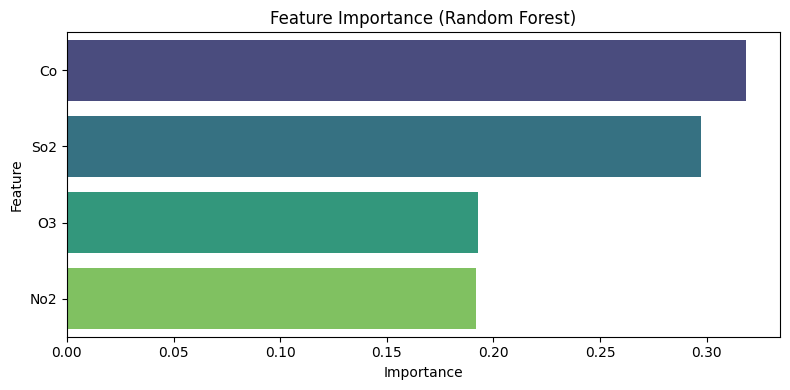

In [49]:
# Feature Importance in ein DataFrame umwandeln
feature_importance_df = pd.DataFrame({
    'Feature': features_rf,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Feature Importance anzeigen mit "Feature" als Hue und deaktivierter Legende
plt.figure(figsize=(8, 4))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df,
            hue='Feature', palette='viridis', dodge=False)
plt.legend([], [], frameon=False)
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout();


Am wichtigsten für die Klassifizierung ist das Feature "CO". Welche Städte wurden falsch klassifiziert?

In [62]:
# Falsch klassifizierte Städte finden
incorrect_predictions = X_test.copy()
incorrect_predictions['True Label'] = y_test
incorrect_predictions['Predicted Label'] = y_pred_rf

# Nur falsch klassifizierte Städte herausfiltern
incorrect_predictions = incorrect_predictions[incorrect_predictions['True Label'] != incorrect_predictions['Predicted Label']]

# CO-Werte der falsch klassifizierten Städte
incorrect_predictions['CO'] = X_test.loc[incorrect_predictions.index, 'Co']

# Ausgabe der Städte mit ihren CO-Werten
# incorrect_predictions[['True Label', 'Predicted Label', 'CO', 'So2', 'O3', 'No2']].sort_values(by='CO', ascending=False)
incorrect_predictions


,Co,No2,O3,So2,True Label,Predicted Label,CO
City,,,,,,,
Budapest,4.4,9.6,18.400,2.3,0,1,4.4
Okayama,3.4,8.4,24.100,5.8,0,1,3.4
Prato,0.1,18.3,35.000,1.6,0,1,0.1
Lampang,0.1,2.9,10.700,1.1,1,0,0.1
Nara-shi,3.4,4.7,24.800,4.3,0,1,3.4
Tuzla,0.1,9.0,10.400,18.1,1,0,0.1
Abu dhabi,0.1,10.8,27.300,5.1,1,0,0.1
Worcester,0.4,4.2,1.575,2.3,0,1,0.4
Suncheon,4.5,7.5,28.100,4.3,0,1,4.5


In [63]:
incorrect_predictions.index

Index(['Budapest', 'Okayama', 'Prato', 'Lampang', 'Nara-shi', 'Tuzla',
       'Abu dhabi', 'Worcester', 'Suncheon', 'San luis potosí', 'Zabrze',
       'Concepción', 'Tainan', 'Douliu', 'Winnipeg'],
      dtype='object', name='City')

Welche Messwerte (Median) haben die Städte im einzelnen?

In [61]:
df_classification.loc[['Budapest', 'Okayama', 'Prato', 'Lampang', 'Nara-shi', 'Tuzla',
          'Abu dhabi', 'Worcester', 'Suncheon', 'San luis potosí', 'Zabrze',
          'Concepción', 'Tainan', 'Douliu', 'Winnipeg']]

,Co,No2,O3,Pm10,Pm25,So2,Num_Valid_Pollutants,AirQualityLabel
City,,,,,,,,
Budapest,4.4,9.6,18.400,17.0,44.0,2.3,6,0
Okayama,3.4,8.4,24.100,14.0,46.0,5.8,6,0
Prato,0.1,18.3,35.000,17.0,46.0,1.6,6,0
Lampang,0.1,2.9,10.700,37.0,68.0,1.1,6,1
Nara-shi,3.4,4.7,24.800,12.0,38.0,4.3,6,0
Tuzla,0.1,9.0,10.400,25.0,67.0,18.1,6,1
Abu dhabi,0.1,10.8,27.300,71.0,93.0,5.1,6,1
Worcester,0.4,4.2,1.575,15.0,23.0,2.3,6,0
Suncheon,4.5,7.5,28.100,23.0,53.0,4.3,6,0


In [51]:
# CO-Werte der falsch klassifizierten Städte
co_values = incorrect_predictions['CO']

# Berechne die wichtigsten Statistiken (Durchschnitt, IQR)
co_mean = co_values.mean()
co_std = co_values.std()
co_min = co_values.min()
co_max = co_values.max()

# Berechne Interquartilsabstand (IQR)
Q1 = co_values.quantile(0.25)
Q3 = co_values.quantile(0.75)
IQR = Q3 - Q1

# Anzeigen der CO-Statistiken
print(f"Durchschnittlicher CO-Wert: {co_mean:.2f}")
print(f"Standardabweichung: {co_std:.2f}")
print(f"Minimaler CO-Wert: {co_min:.2f}")
print(f"Maximaler CO-Wert: {co_max:.2f}")
print(f"Interquartilsabstand (IQR): {IQR:.2f}")


Durchschnittlicher CO-Wert: 2.86
Standardabweichung: 3.18
Minimaler CO-Wert: 0.10
Maximaler CO-Wert: 12.40
Interquartilsabstand (IQR): 3.70


Man sieht, dass das Modell vor allem dann falsch klassifiziert, wenn das Feature mit der höchsten Feature Importance (CO) unerwartet niedrig ist.

Ich glaube nicht, dass man da noch viel drehen kann. Das Modell ist eigentlich recht gut, wenn man bedenkt, dass die Messwerte zum Teil recht abenteuerlich sind.

# 7. Gradient Boosting

Gradient Boosting ist ein sequentielles Ensemble-Verfahren, bei dem schwache Lernmodelle – meist kleine Entscheidungsbäume – iterativ trainiert werden, um die Fehler der vorherigen Modelle zu korrigieren. Das Modell optimiert dabei schrittweise eine Verlustfunktion mithilfe von Gradientenabstieg, was zu einer sehr präzisen Vorhersage führt.

Zu den Vorteilen zählen eine hohe Leistungsfähigkeit und die Fähigkeit, komplexe Zusammenhänge zu erfassen. Allerdings kann Gradient Boosting bei unzureichender Abstimmung der Hyperparameter schnell überanpassen und ist in der Regel rechenintensiver als einfachere Modelle.

In [64]:
# Gradient Boosting Modell erstellen
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Modell trainieren
gb_model.fit(X_train, y_train)

# Vorhersagen & Bewertung
y_pred_gb = gb_model.predict(X_test)
print(classification_report(y_test, y_pred_gb))
# print(confusion_matrix(y_test, y_pred_gb))


              precision    recall  f1-score   support

           0       0.86      0.80      0.83        40
           1       0.82      0.88      0.85        42

    accuracy                           0.84        82
   macro avg       0.84      0.84      0.84        82
weighted avg       0.84      0.84      0.84        82



In [65]:
cm_gb = confusion_matrix(y_test, y_pred_gb)

cm_df = pd.DataFrame(cm_gb, 
                     index=["Tatsächlich Negativ", "Tatsächlich Positiv"], 
                     columns=["Vorhergesagt Negativ", "Vorhergesagt Positiv"])

print(cm_df)

                     Vorhergesagt Negativ  Vorhergesagt Positiv
Tatsächlich Negativ                    32                     8
Tatsächlich Positiv                     5                    37


Gradient Boosting erreicht mit 84% noch einmal einen leicht höheren F1-Score. Auch diese Modell erscheint einigermaßen ausgewogen (5 false negatives zu 8 false positives).